
<img src="https://cmse.msu.edu/_cmse/assets/Image/CMSE-bigger.png"
     alt="CMSE Grapical Image"
     align="left" 
     height="82" 
     width="82" />
 
 <img src="https://cdn.jamanetwork.com/ama/content_public/journal/jama/4953/m_jpg1124f1.jpeg?Expires=2147483647&Signature=wEAZM45MnrhQryVXyhjrcwAcyo1vnOwr-MQEz1gtwOfkON5zrdRR7jlNd38tNf9679dj7YNmOtMolQ0YluVUslQ1KbrdPeeu4XNkyaYPn50lfine6gfsglDVpdssU-NKLF1LANxQj1K2boHgPN0Yww7mBoq~2ky~MQPzpAbbF7D-bLL-99P7gMjXw7aOPsXgJM5cuSPWBgk2mZxzD2kWmwtkMBaqkBig~0qLd2FaZ6Ql7ZmiWpffcPMXmMg~nBiWXH0687v5gKyACXPhkosz64O3oynVGcnJD6G~TrqBBLIK1vKl2IRQbmlZicNqHW9tF0kc3X5K5Gd78gtkR9w3VQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA"
     alt="CAD"
     align="right"  
     width="200" />  
     
## __CMSE  201 - Spring 2019__


## Homework 6: Model Optimization using Monte Carlo Methods

### Using Markov Chain Monte Carlo approach to optimize a compartmental model


Heart Disease is the leading cause of death throughout the world.  The most common form of heart disease is <a href="https://my.clevelandclinic.org/health/diseases/16898-coronary-artery-disease">**coronary artery disease**</a> which is the narrowing or blockage of the coronary arteries that can lead to acute events such as a heart attack and/or chronic conditions such as stable chest pain.  There are several non-invasive tests to evaluate coronary artery disease.  One advanced method is to use Cardiac <a href="https://en.wikipedia.org/wiki/Positron_emission_tomography">Positron Emission Tomography (PET)</a>.  This approach relies on fitting a compartmental model to measured data.  The goal of this assignment is to perform this fitting on sample patients to identify high risk individuals.




## Goals

### By the end of the homework assignment you will have practiced:

1. Loading data using pandas,
2. Reading and using pre-existing code to solve complex problems,
3. Use of compartmental models,
4. Generating and applying random numbers for different applications,
5. Developing a Markov Chain Monte Carlo optimization technique to fit a model to measured data.


## Assignment instructions

Work through the following assignment, making sure to follow all of the directions and answer all of the questions.

**This assignment is due roughly two weeks from now at 11:59pm on Friday, April 12th.** It should be uploaded into the "Homework Assignments" dropbox folder for Homework 6.  Submission instructions can be found at the end of the notebook.

## Grading


* Part 1: Background and exploring patient data with pandas (11 points)
   - Question 1 (1 points)
   - Question 2 (2 points)
   - Question 3 (4 points)
   - Question 4 (4 points)

* Part 2: Solving the blood-tissue exchange in myocardial muscle compartmental model (17 points)
   - Question 5 (4 points)
   - Question 6 (3 points)
   - Question 7 (5 points)
   - Question 8 (4 points)
   - Question 9 (1 point)

* Part 3: Optimization of a compartmental model (17 points)
   - Question 10 (3 points)
   - Question 11 (5 points)
   - Question 12 (3 points)
   - Question 13 (3 points)
   - Question 14 (3 points)

Total points possible: **45**

---
## Part 1: Background and exploring patient data with pandas (11 points)

**Question 1**: Make sure you set up your notebook to produce matplotlib plots and import the right modules (numpy, pandas, scipy). Do that here.


In [176]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy import special, optimize
import random
%matplotlib inline

### Background

Cardiac Positron Emission Tomography (PET) is a non-invasive imaging study.  In this study, a radioactive tracer is injected into the patient.  This tracer is a radioactive version of ammonia (NH$_3$).  This tracer circulates through the body and interacts with the myocardial muscle of the heart.  In short, the tracer arrives to the muscle, enters the muscle, and a portion of it is trapped in the muscle.  The arrival of the tracer follows a certain time course, which we will call the **input function** (function describing input of tracer into the capillaries next to myocardial muscle).  The PET scanner images this time course and makes a measure of the input function, $C_{in}(t)$, and of the **myocardial response**, $C_{m}(t)$.  The total system is represented in this graphic:

<img src="http://www.egr.msu.edu/~aalessio/imgs/NH3_2comp.png"
     alt="2Comp" 
     width="400" />  


This follows the traditional compartmental modeling approaches we have used in class with a few minor differences.  In this model, the capillary is a region with a known response (it is measured from the images).  Since this is known, we do not need to model its change in our equations.  The ordinary differential equations to represent this system are:

\begin{eqnarray}
\frac{dC_1}{dt} &=& k_1C_{in}(t) - k_2C_1 - k_3C_1  \\
\frac{dC_2}{dt} &=& k_3C_1 \\
\end{eqnarray}

where $k_1$, $k_2$, $k_3$ are rate constants describing the movement of N-13 (the radioactive, imagable component of the tracer) in this system.  In this application, we will measure the total N-13 in the myocardial muscle, which is $C_m = C_1 + C_2$. 

These types of models (of varying levels of complexity) are widely used to answer questions related to blood-tissue exchange.  For example, if a drug enters the blood supply, how does it interact with the tissue?  How long does it stay in the tissue?  What parts of the tissue (inside cells, in extracellular fluid, etc) are involved?  Does the drug change states while in the tissue?  

For this problem, $k_1$ is effectively the blood perfusion to the myocardial muscle.  In other words, it represents the rate of delivery of blood to the myocardial muscle.  The myocardial muscle is arguably the hardest working muscle in the human body, responsible for pumping blood to the rest of the body.  In a lifetime, the human heart will pump over 2.5 billion times and moves over 200 million liters of blood.  The heart muscle requires blood to work effectively and to stay alive.  If the perfusion is low, then a portion of muscle may die (this is what happens during a heart attack).  When a person exercises or is under stress, the heart is required to work harder and as a result the heart needs more blood to feed its muscle and perfusion increases.  In a healthy human heart, during a stressed state, the myocardial perfusion should be 2-4 ml/min/gram of tissue.  If the heart is diseased, the stress myocardial perfusion will be less than 2 ml/min/gram.  Therefore, in our model, if we find that **$k_1$ is below 2 ml/g/min**, then the patient has a problem with their heart, reflective of ongoing coronary artery disease.

For this assignment, we are going to work through the following general steps:
1. We have a model of this system, but do not know the patient specific values for $k_1$ and $k_2$ (We will assume $k_3$ is constant for all patients).
2. We have measured $C_m$ curves from 2 patients (each curve comes from a patient with different $k_1$ and $k_2$ parameters).
3.  We need to devise a method to fit the compartmental model (by finding the optimal $k_1$ and $k_2$ parameters) to the measured $C_m$ curves.



**Question 2**: Using pandas, load the 2 data files that were provided with this notebook: patient1.csv, patient2.csv. These data files contain simulated measurements of the concentration of NH3 in the capillary region, $C_{in}$, and in the whole myocardial muscle region, $C_m$.  The units for time are seconds (basically one measurement every 5 seconds) and for the $C_{in}$ and $C_m$ curves are **concentrations in kBq/cc** (a measure of radioactivity per cubic centimeter).  



In [177]:
patient1=pd.read_csv('patient1.csv')
patient2=pd.read_csv('patient2.csv')

**Question 3**: Make one plot for each patient containing both the input function vs times and myocardial muscle response vs time.  (All plots should contain axes labels, title, and legend).

These curves should show the input function, $C{in}$, rising quickly before the myocardial tissue response function, $C_m$.  This represents the NH3 rapidly moving through the blood and the NH3 gradually entering and trapping in the myocardial tissue.

<hr>

While the input function is measured, we are going to assume we can generate this curve with a known function.  The following code is provided to generate the input function (this assumes that we know the exact equation for the input function). Read this code to understand what is does.  

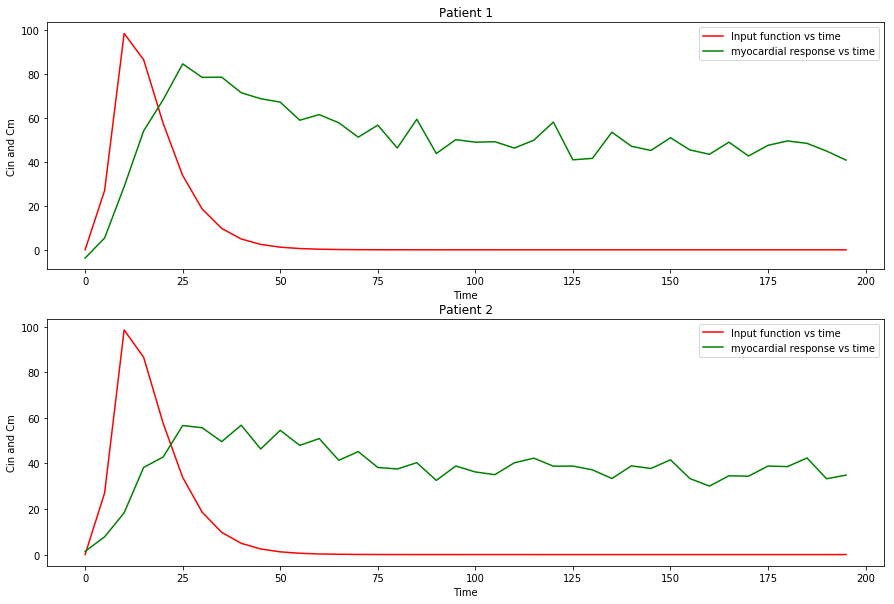

In [179]:
## Functions for generating input function

# Returns input function in an array at all times
def gamma_variate_array(times):
    td = 4 # arrival delay
    tp = 7 # time to peak
    a = 1.2 # shape
    ymax = 100 # max value
    f = []
    for t in times:
        if t<td:
            f.append(0.0)
        else:
            f.append(ymax* ((t-td)/tp)**a * math.exp(a - a*((t-td)/tp)))
            
    return np.array(f)
                   
# Returns single value of input function at time t
def gamma_variate1(t):
    td = 4 # arrival delay
    tp = 7 # time to peak
    a = 1.2 # shape
    ymax = 100 # max value
    if t<td:
        f=0.0
    else:
        f =ymax* ((t-td)/tp)**a * math.exp(a - a*((t-td)/tp))       
    return f

# Returns single value of input function at time t (same as gamma_variate1())
# This definition is a repeat of above just to provide a name that matches the diagram
def Cin_estimated_func(t):
    return gamma_variate1(t)

fig = plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(patient1['time (sec)'], patient1['input_function'], "r", label="Input function vs time")
plt.title("Patient 1")
plt.plot(patient1['time (sec)'], patient1['myocardial_response'], "g", label="myocardial response vs time")
plt.xlabel("Time")
plt.ylabel("Cin and Cm")
plt.legend(loc="best")


plt.subplot(2,1,2)
plt.plot(patient2['time (sec)'], patient2['input_function'], "r", label="Input function vs time")
plt.title("Patient 2")
plt.plot(patient2['time (sec)'], patient2['myocardial_response'], "g", label="myocardial response vs time")
plt.xlabel("Time")
plt.ylabel("Cin and Cm")
plt.legend(loc="best")

**Question 4**: Now, use the above function `gamma_variate_array()` to make an array containing $C_{in}$ at all of the times present in the data file for patient 1.  Plot the array you generated versus time.  In this same figure, plot the values in 'input_function' from the `patient1.csv` file vs time. Add a legend for each curve. **Hint:** These should be identical curves. (remember to label axes).

Text(0, 0.5, 'Cin')

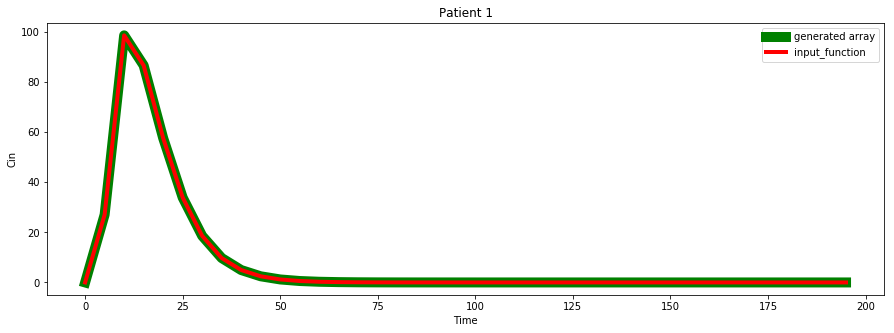

In [180]:
cin=gamma_variate_array(patient1['time (sec)'])

fig = plt.figure(figsize=(15,5))
plt.plot(patient1['time (sec)'], cin, "g" ,linewidth=10, label="generated array")
plt.plot(patient1['time (sec)'], patient1['input_function'], "r",linewidth=4, label="input_function")
plt.title("Patient 1")
plt.legend(loc="best")
plt.xlabel('Time')
plt.ylabel("Cin")

If successful, the curve you generated with `gamma_variate_array()` should be identical to the values in 'input_fuction' in the patient file.  This basically shows that you already have a fitted curve for $C_{in}$ and can use this function anytime you need to know the value of $C_{in}$ at any time.  Moreover, for simplicity, we made $C_{in}(t)$ identical for all the patient files.

## Part 2: Solving the blood-tissue exchange in myocardial muscle compartmental model (17 points)
Now, we will solve for one fixed set of parameters for this compartmental model.  The following code defines the ordinary differential equations for this problem.

In [181]:
# Model of blood tissue exchange for NH3 PET Imaging
def nh3_ode_equations(state,t,Cin,k1,k2,k3):
   
    C1 = state[0]
    C2 = state[1]
    
    #dCindt = 
    k1_sec = k1 / 60 # original parameters are in ml/min/g, this converts to ml/sec/g
    k2_sec = k2 / 60
    k3_sec = k3 / 60
    dC1dt = k1_sec*Cin(t) - k2_sec*C1 - k3_sec*C1
    #dC1dt =  - k2*C1 - k3*C1
      
    dC2dt = k3_sec*C1
    
    return [dC1dt,dC2dt]

**Question 5:** Solve these ordinary differential equations for the single set of parameters $k_1, k_2, k_3 = 2.6, 1.2, 1.0 $/min respectively.  Use the initial conditions of $C_1(0) = 0$ and $C_2(0) = 0$.

In [182]:
# Complete the code below

# Considering this problem will require varying the rate constants in 
# order to find the best rate constant, we would like to pass these into 
# the function (not fix them to a value)
# 
# To pass arguments into odeint(), put them in a tuple and pass as the 4th input to odeint()
# for example: 
#    args = (P1, P2, P3, P4)
# Then call odeint() with 
#    odeint(func, y0, t, args)
# (This is the same call you have used before with the addition of "args")
# Note: P1, P2, P3, P4 need to be the correctly ordered variables 
#       that match the order defined in the nh3_ode_equations() definition 
# The code performing this is provided below:
k1,k2,k3=2.6,1.2,1.0
init_conditions=[0,0]
args = (Cin_estimated_func,k1,k2,k3)  # More specifically, the first argument here is a function and the other 3 arguments are rates
sol = odeint(nh3_ode_equations,init_conditions,patient1['time (sec)'],args)

**Question 6:** Make a plot of the values of $C_1$, $C_2$, and $C_m$ versus time.  Be sure to label the axis and include a legend.

Text(0.5, 1.0, 'C1 , C2, and Cm versus time')

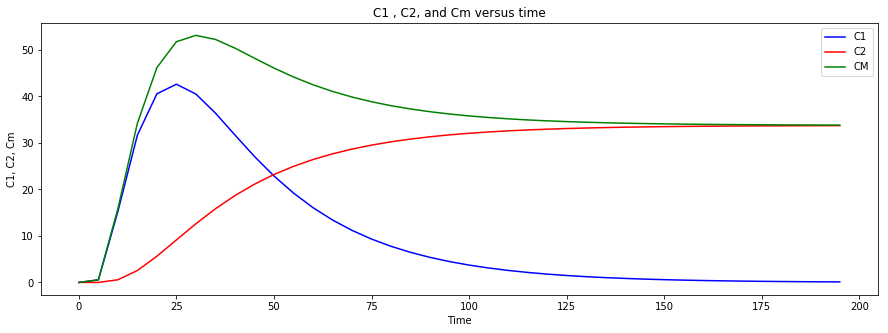

In [183]:
fig = plt.figure(figsize=(15,5))
plt.plot(patient1['time (sec)'], sol[:, 0], 'b', label='C1')
plt.plot(patient1['time (sec)'], sol[:, 1], 'r', label='C2')
plt.plot(patient1['time (sec)'],sol[:,0]+sol[:,1],"g", label="CM")
plt.legend(loc="best")
plt.xlabel('Time')
plt.ylabel("C1, C2, Cm")
plt.title("C1 , C2, and Cm versus time")

This plot provides the solution for each compartment for one set of parameters (one set of rate constants). 

**Question 7:** Define a single function that has five inputs ($k_1, k_2, k_3$ parameters, $C_{in}$, and a time array), solves the system of ordinary differential equations using `odeint()`, and returns the array containing $C_m$.  (This is basically taking the code you wrote above and puts it in a function).  Run this function once (for $k_1, k_2, k_3 = 2.6, 1.2, 1.0 $/min respectively) and plot the result of this function to make sure it matches the result above.

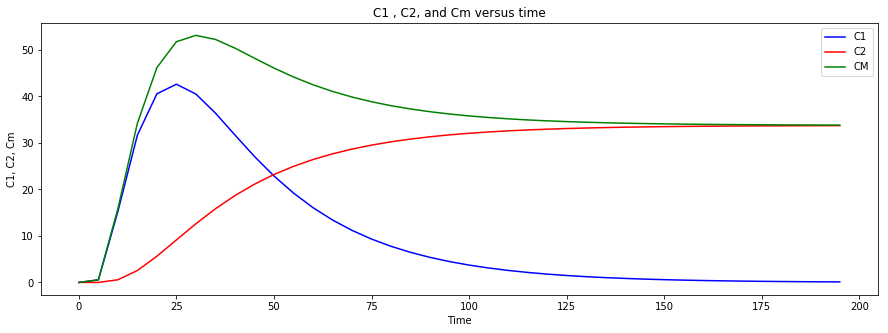

In [184]:
def s_o_d_e(k1,k2,k3,cin ,t):
    sol = odeint(nh3_ode_equations,cin,t,(Cin_estimated_func,k1,k2,k3))
    return sol[:,0]+sol[:,1]

fig = plt.figure(figsize=(15,5))
plt.plot(patient1['time (sec)'], sol[:, 0], 'b', label='C1')
plt.plot(patient1['time (sec)'], sol[:, 1], 'r', label='C2')
plt.plot(patient1['time (sec)'],s_o_d_e(2.6,1.2,1.0,[0,0],patient1['time (sec)']),"g",label="CM")
plt.xlabel("Time")
plt.ylabel("C1, C2, Cm")
plt.title("C1 , C2, and Cm versus time")
plt.legend()

**Question 8:** Using your function from question 7, make three $C_m$ curves for three hypothetical patients with $k_1$ = 0.5, 2.0, 4.0 ml/min/g, representing poor perfusion, adequate perfusion, and great perfusion.  Keep $k_2$ =1.2 /min and $k_3$ = 1.0 /min.  Make a single plot with all three curves (include a legend).

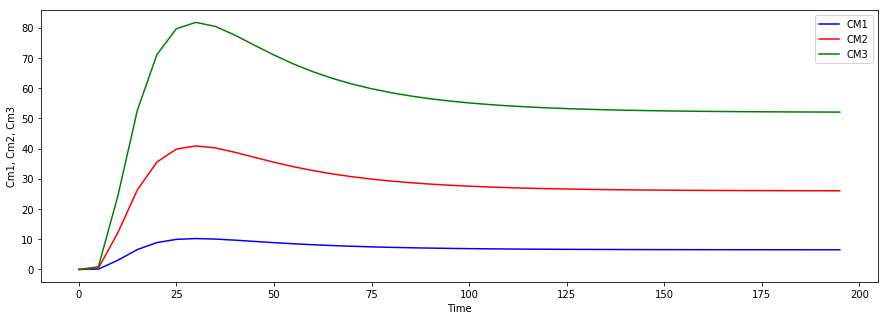

In [185]:
fig = plt.figure(figsize=(15,5))
plt.plot(patient1['time (sec)'],s_o_d_e(0.5,1.2,1.0,[0,0],patient1['time (sec)']),"b",label="CM1")
plt.plot(patient1['time (sec)'],s_o_d_e(2.0,1.2,1.0,[0,0],patient1['time (sec)']),"r",label="CM2")
plt.plot(patient1['time (sec)'],s_o_d_e(4.0,1.2,1.0,[0,0],patient1['time (sec)']),"g",label="CM3")
plt.xlabel("Time")
plt.ylabel("Cm1, Cm2, Cm3")
plt.legend()

**Question 9:** What do you observe changing about these curves as the perfusion increases?

The higher the perfusion, the higher the decrease through the time

---
## Part 3: Optimization of a compartmental model (17 points)



The goal of this work is to fit the compartmental model discussed above to the myocardial response curves.  In other words, we need to find the optimal $k_1$ and $k_2$ that best fits the measured myocardial curve.  We will use a Monte Carlo based approach for this (using random steps to approach optimal solution).

This portion of the assignment will develop a method to minimize the chi squared error between the measured data and the estimated data from the compartmental model.  The function to calculate the chi squared error is provided below (same as the function used for the Day 21 in-class assignment).

In [186]:
def chi_squared_error(ydata_measured,ydata_estimated,sigma):
    '''
    Takes in the 1) observed/measured data, 2) our model's estimated y-values 
    for the model, and 3) our estimate for the sigma (noise) in the data.
    
    Returns sum-of-squares error (chi-squared error) 
    '''
    
    return ((ydata_measured-ydata_estimated)**2/(2*sigma**2)).sum()/(ydata_estimated.size)

**Question 10:** Use the above function to calculate the chi square error between the measured $C_m$ for patient 1 and an estimated $C_m$ (for a single arbitrary set of parameters $k_1, k_2, k_3 = 2.6, 1.2, 1.0 $/min respectively).  Print the chi square error.

In [187]:
# Put your code here
sigma = 1    # Assumed noise in the measured Cm curve

chi_error=chi_squared_error(patient1['myocardial_response'],s_o_d_e(2.6,1.2,1.0,[0,0],patient1['time (sec)']),sigma)

print("The chi error is:",chi_error)

The chi error is: 133.4991067599495


### Implement the Metropolis-Hastings algorithm 

Implement the algorithm described in the Day 21 In-Class assignment.  In brief, the general idea behind MCMC fitting of our data is that we will start from a guess at our model parameters and "walk" in random directions in parameter space in a way that on average gets us closer to the best fit to the data.  

For this problem, we are going to assume that $k_3$ is constant across all patients under the assumption that the trapping rate of the tracer does not change with disease.  We will assume $k_3 = 1.0$ / min.

**Question 11:** Now you're on your own! Set up a MCMC fitting of the proposed compartmental model, which generates an estimated myocardial response curve, to the measured myocardial response data. We have the starting setup and initial conditions below.



In [188]:
# Enforce assumption that k3 is fixed
k3 = 1.0 # 1/min

# Total number of points we're going to sample (start out with at least 10^4)
num_sample_points = 10000

# Weight factor in front of the random step
step_size = 0.02

# Provide an initial guess for the k1 and k2 parameters
# As we move the walker around, we'll use these same lists to 
# store our new values so that we can visualize the path later!
# (Note: that means you'll want to append new values to these lists!)
k1_list = [2]
k2_list = [2]

sigma = 1    # Assumed noise in the measured Cm curve

### Put your code here ###
error1=chi_squared_error(patient1['myocardial_response'],s_o_d_e(k1_list[0],k2_list[0],k3,[0,0],patient1['time (sec)']),sigma)

for i in range(num_sample_points):
    random1=random.uniform(-1,1)
    random2=random.uniform(-1,1)
    
    error2=chi_squared_error(patient1['myocardial_response'],s_o_d_e(random1*step_size+k1_list[-1],random2*step_size+k2_list[-1],k3,[0,0],patient1['time (sec)']),sigma)
    
    probability=(math.e**(-chi_squared_error(patient1['myocardial_response'],s_o_d_e(random1*step_size+k1_list[-1],random2*step_size+k2_list[-1],k3,[0,0],patient1['time (sec)']),sigma)))/(math.e**(-error1))
    
    if random.uniform(0,1)<probability:
        k1_list.append(random1*step_size+k1_list[-1])  
        k2_list.append(random2*step_size+k2_list[-1])  
        error1=error2

**Question 12:** Make a plot of where the random walker went (a plot of $k_1$ vs $k_2$) for patient 1.  What is the final estimated value for $k_1$ and $k_2$? (label axes)

The final estimated values are 4.410410002618934 and 1.708836243073594


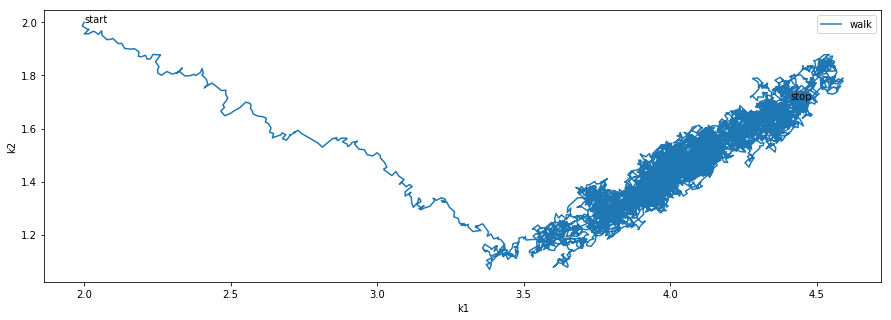

In [189]:
fig = plt.figure(figsize=(15,5))

plt.plot(k1_list, k2_list, label="walk")
plt.annotate('start', xy=(k1_list[0], k2_list[0]))
plt.annotate('stop', xy=(k1_list[-1], k2_list[-1]))
plt.xlabel("k1")
plt.ylabel("k2")
plt.legend(loc="best")

print("The final estimated values are",k1_list[-1],"and",k2_list[-1])

**Question 13:** Make plot of the optimal computed model overlayed with the measured data for patient 1.  How well does your model fit the data (describe in words)?

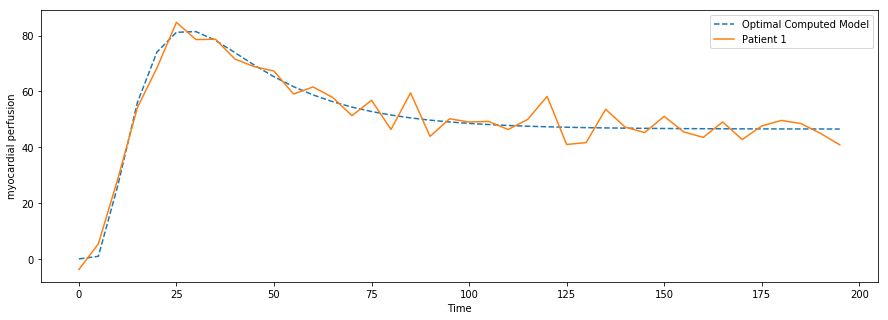

In [190]:
fig = plt.figure(figsize=(15,5))

plt.plot(patient1['time (sec)'],s_o_d_e(k1_list[-1],k2_list[-1],1.0,[0,0],patient1['time (sec)']),'--',label="Optimal Computed Model")
plt.plot(patient1['time (sec)'],patient1['myocardial_response'],label="Patient 1")
plt.xlabel("Time")
plt.ylabel("myocardial perfusion")
plt.legend(loc="best")

**Question 14:** Using the same procedure above, fit the model parameters to the myocardial curve from patient 2.  Answer these following questions: 

A. What is the final estimated value for $k_1$ vs $k_2$ for patient 2?  


In [191]:
k1_list = [2]
k2_list = [2]

error1=chi_squared_error(patient2['myocardial_response'],s_o_d_e(k1_list[0],k2_list[0],k3,[0,0],patient2['time (sec)']),sigma)

for i in range(num_sample_points):
    random1=random.uniform(-1,1)
    random2=random.uniform(-1,1)
    
    error2=chi_squared_error(patient2['myocardial_response'],s_o_d_e(random1*step_size+k1_list[-1],random2*step_size+k2_list[-1],k3,[0,0],patient2['time (sec)']),sigma)
    
    probability=(math.e**(-chi_squared_error(patient2['myocardial_response'],s_o_d_e(random1*step_size+k1_list[-1],random2*step_size+k2_list[-1],k3,[0,0],patient2['time (sec)']),sigma)))/(math.e**(-error1))
    
    if random.uniform(0,1)<probability:
        k1_list.append(random1*step_size+k1_list[-1])  
        k2_list.append(random2*step_size+k2_list[-1])  
        error1=error2
        
print("The final estimated values are",k1_list[-1],"and",k2_list[-1])

The final estimated values are 2.9682185303010935 and 1.4070307461786953


B. Did the model fit the measured curve well? How can you tell?   

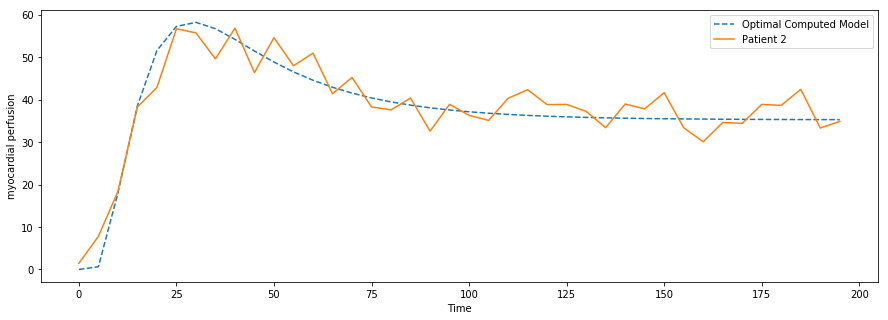

In [192]:
fig = plt.figure(figsize=(15,5))

plt.plot(patient2['time (sec)'],s_o_d_e(k1_list[-1],k2_list[-1],1.0,[0,0],patient2['time (sec)']),'--',label="Optimal Computed Model")
plt.plot(patient2['time (sec)'],patient2['myocardial_response'],label="Patient 2")
plt.xlabel("Time")
plt.ylabel("myocardial perfusion")
plt.legend(loc="best")

C. Between patient 1 and 2, who had the better myocardial perfusion?

In [193]:
print("Patient 1 had a better myocardial perfusion compared to the patient 2")

Patient 1 had a better myocardial perfusion compared to the patient 2


---
## Assignment wrap-up

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credit for the assignment!**

In [171]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/UHGpbxFjHFjfRhwH7" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

---

### Congratulations, you're done!

Submit this assignment by uploading it to the course Desire2Learn web page.  Go to the "Homework Assignments" folder, find the dropbox link for Homework #6, and upload it there.